In [1]:
# SPM_Assignment_5 
# Name :Rupa Rajendran
# Student ID:A20460455 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import date
import dateutil.relativedelta

import pandas as pd                                    # panda's nickname is pd

import numpy as np                                     # numpy as np

from pandas import DataFrame, Series                   # for convenience

import matplotlib.pyplot as plt

%matplotlib inline

import pandas as pd

from fbprophet import Prophet

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

import tensorflow as tf
from tensorflow.contrib.timeseries.python.timeseries import  NumpyReader
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import time

In [74]:
#load data.
df = pd.read_csv('issues.csv')
print(df)


      issue_number OriginationPhase DetectionPhase     Category  Priority  \
0                1     Requirements         Coding          Bug  Critical   
1                2           Design        Testing  Enhancement      High   
2                3     Requirements         Design      Inquiry       Low   
3                4          Testing          Field          Bug      High   
4                5    Documentation          Field  Enhancement     Major   
...            ...              ...            ...          ...       ...   
1995          1996           Design         Coding      Inquiry       Low   
1996          1997          Testing          Field          Bug    Medium   
1997          1998    Documentation          Field  Enhancement     Major   
1998          1999           Design         Coding      Inquiry      High   
1999          2000           Design         Coding      Inquiry      High   

             Status  created_at   closed_at   Author  
0          Approved 

In [75]:
df.tail()

,issue_number,OriginationPhase,DetectionPhase,Category,Priority,Status,created_at,closed_at,Author
1995,1996,Design,Coding,Inquiry,Low,Rejected,06-06-2017,08-04-2017,Zachary
1996,1997,Testing,Field,Bug,Medium,Completed,06-07-2017,NaN,Tamara
1997,1998,Documentation,Field,Enhancement,Major,Rejected,06-08-2017,NaN,Eric
1998,1999,Design,Coding,Inquiry,High,pendingReview,4-14-2017,NaN,Lindsey
1999,2000,Design,Coding,Inquiry,High,Completed,06-10-2017,NaN,John


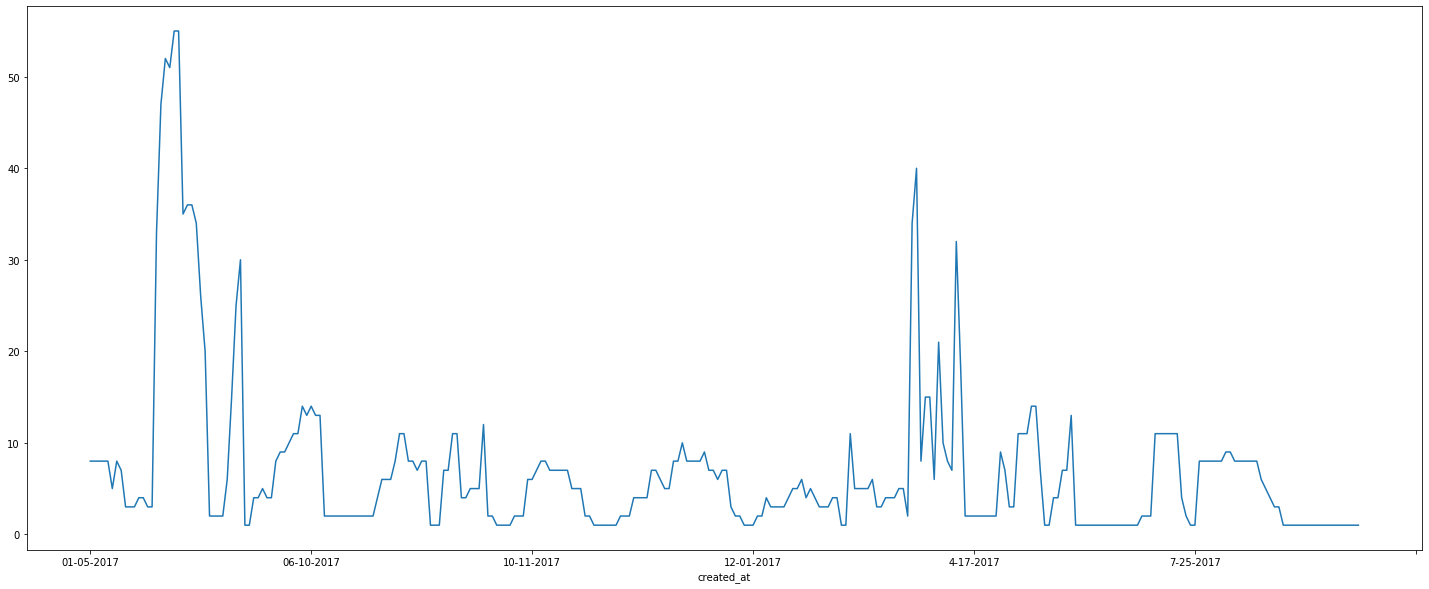

In [76]:
DailyIssue = df.groupby(['created_at']).created_at.count()
DailyIssue.plot(figsize= (25, 10))
#Data = DataFrame(DailyIssue)

In [77]:
df1 = df.groupby(['created_at'], as_index = False).count()
dataFrame = df1[['created_at','issue_number']]
dataFrame.columns = ['ds', 'y']
dataFrame
dataFrame.to_csv (r'github_data.csv', index = None, header=True) 


In [78]:
#facebook prophet
dataFrame = pd.read_csv('github_data.csv')
m = Prophet()
m.fit(dataFrame)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
#facebook
#make predict
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
648,2018-12-18
649,2018-12-19
650,2018-12-20
651,2018-12-21
652,2018-12-22


In [80]:
#facebook prophet
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
648,2018-12-18,-8.748293,-20.096483,1.412438
649,2018-12-19,-8.940750,-19.208459,1.305377
650,2018-12-20,-8.651966,-19.632815,1.430183
651,2018-12-21,-8.558134,-19.540155,2.256645
652,2018-12-22,-9.372622,-19.922845,0.577500


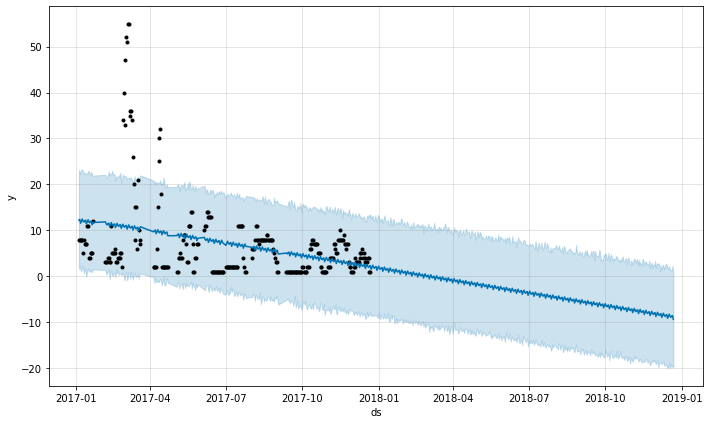

In [81]:
#facebook prophet
forcast_fig1 = m.plot(forecast)

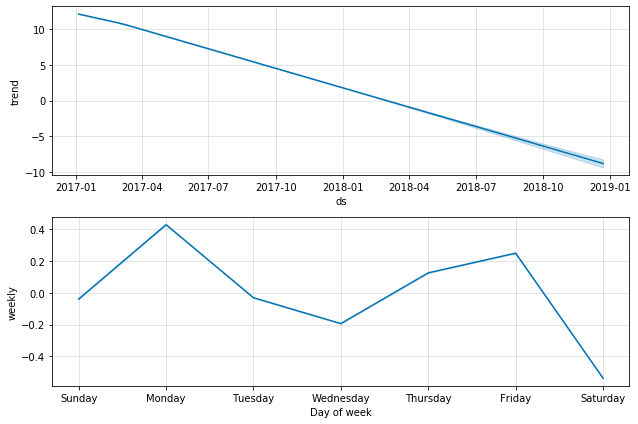

In [82]:
#facebook prophet
forcast_fig2 = m.plot_components(forecast)

33.38710551828214
0


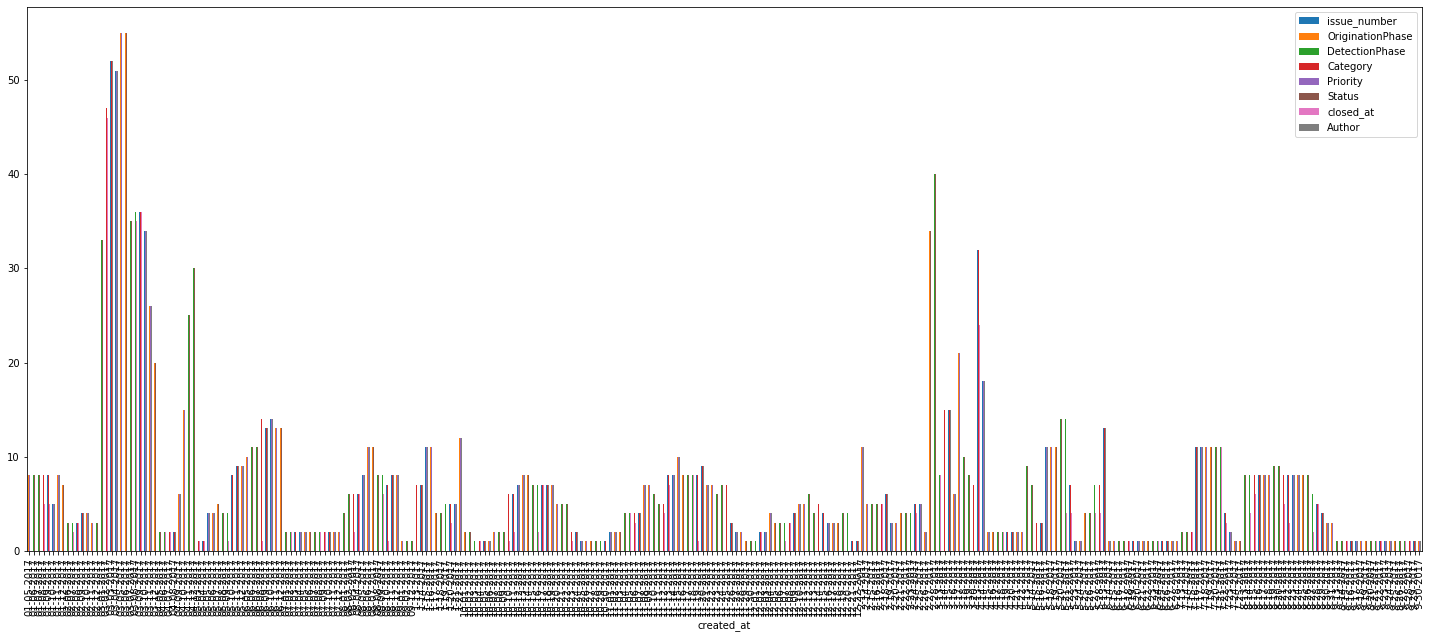

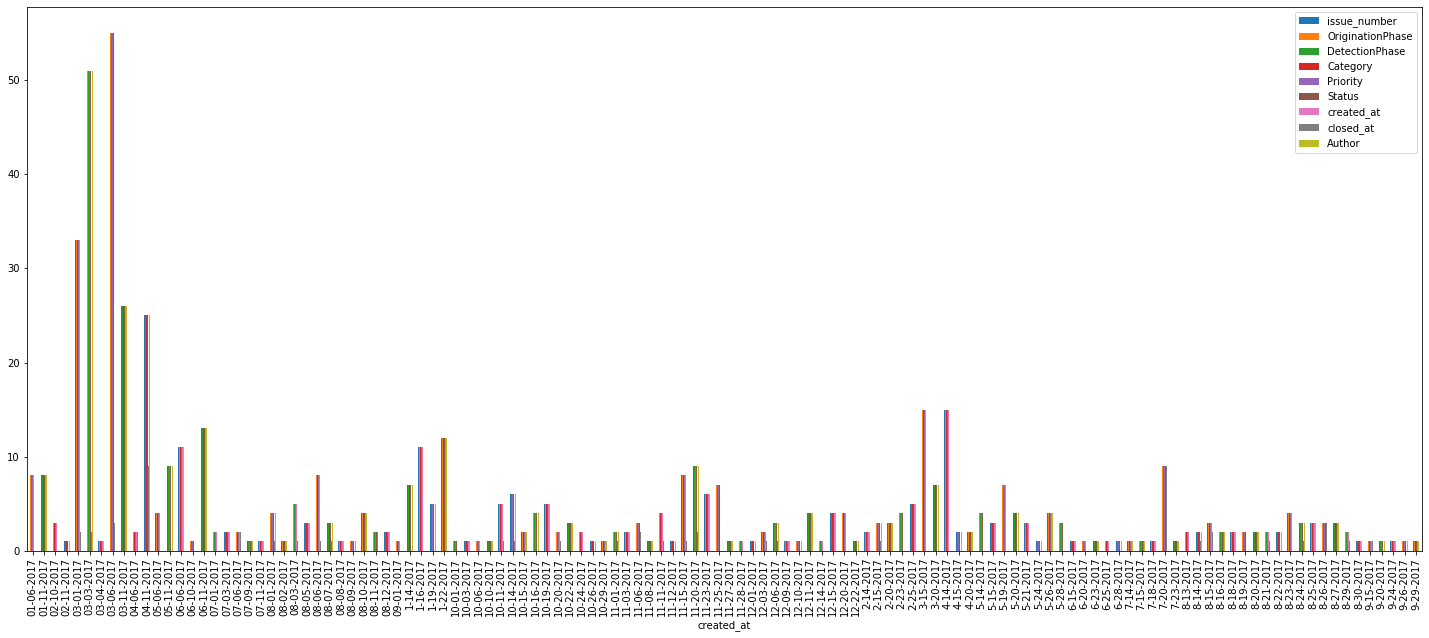

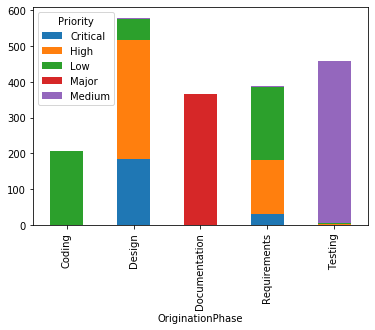

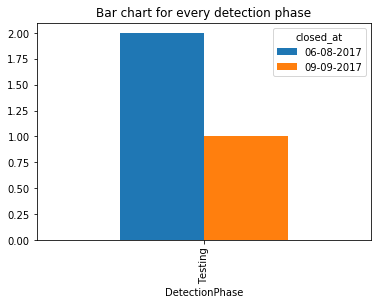

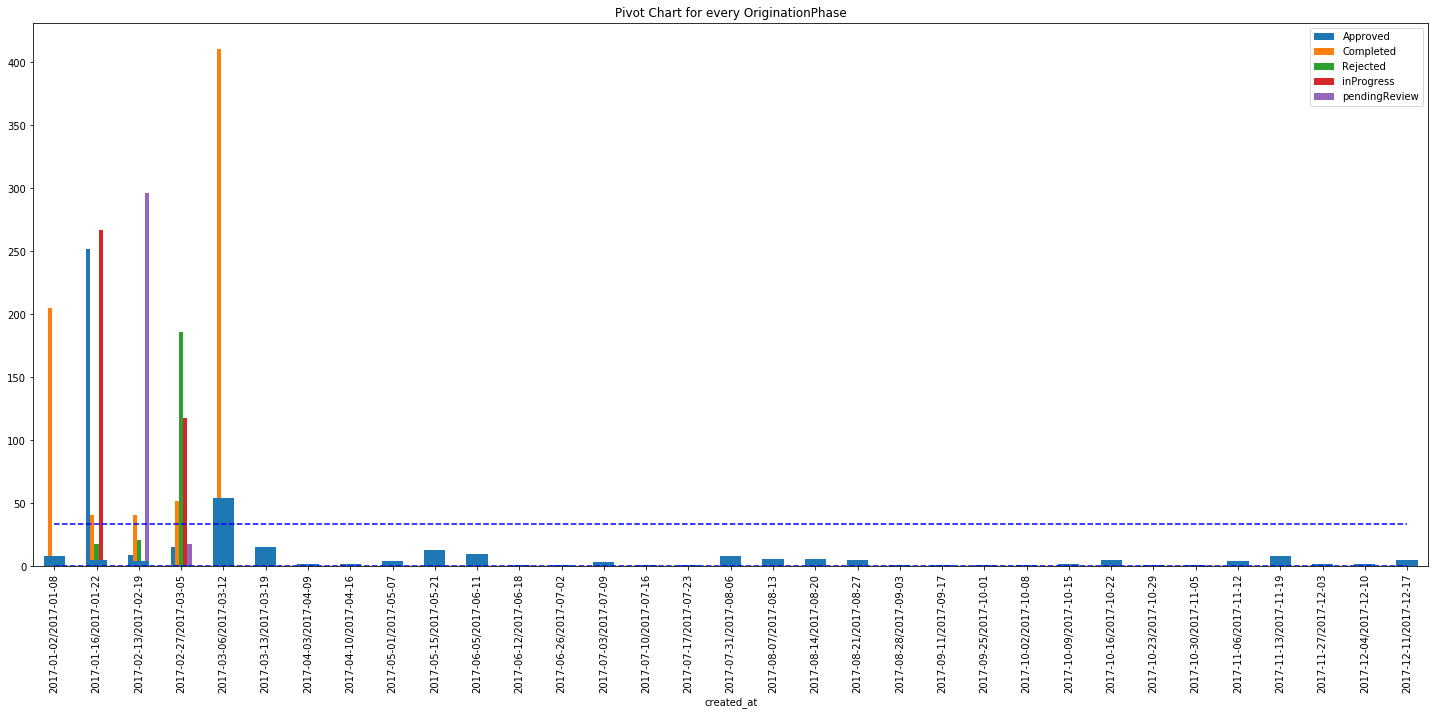

In [83]:
#  i) Plot in Bar Chart the total number of issues created every day
issues = df.groupby(df.created_at).count()
issues.plot.bar(figsize = (25,10))


# ii. Plot in Bar Chart the total number of issues created everyday and originated in Design phase
issues = df[df.OriginationPhase=="Design"].groupby(df.created_at).count()
issues.plot.bar(figsize = (25,10))

# iii. Plot in Stacked Bar Chart the total number of issues based on their priorities created for every originating phase
plot3=df.groupby(['OriginationPhase','Priority']).count().unstack('Priority').fillna(0)
plot3['issue_number'].plot.bar(stacked=True)


# iv. Plot in Bar Chart the total number of issues closed in every day for every DetectionPhase that have labels (Category:Bug,Priority:Critical, Status:Completed)
plot4 = df[(df['Category']=="Bug") & (df['Priority']=='Critical') & (df['Status']=='Completed')].groupby(['DetectionPhase','closed_at']).count().unstack('closed_at').fillna(0)
plot4['issue_number'].plot.bar(title="Bar chart for every detection phase")


# v. Plot in Pivot Chart the total number of issue status created for every OriginationPhase (group by originating phase)
plot5 = df.pivot_table(values='issue_number',index='OriginationPhase',columns='Status',aggfunc=lambda x: len(x)).fillna(0)
ax=plot5.plot.bar(title="Pivot Chart for every OriginationPhase")
ax.legend(loc="upper left",bbox_to_anchor=(1,1))


# vi. Plot in Control Chart for the total number of Critical issues created every week and originated in Design phase. Your Control chart must plot/show the UCL (Upper Control Limit) and LCL (Lower Control Limit)

plot6 = (df[(df['Priority']=='Critical') & (df['OriginationPhase']=='Design')].groupby(pd.to_datetime(df.created_at).dt.to_period("W")).count()).iloc[:,2]
ax=plot6.plot.bar(figsize=(25,10))
ucl = np.mean(plot6.values)+3*np.std(plot6.values)
print(ucl)
lcl = np.mean(plot6.values)-3*np.std(plot6.values)
if lcl<0:
    lcl=0
print(lcl)

ax.hlines(ucl, ax.get_xticks().min(), ax.get_xticks().max(), linestyle='--', color='blue')
ax.hlines(lcl, ax.get_xticks().min(), ax.get_xticks().max(), linestyle='--', color='blue')

In [84]:
# 1. The day of the weeek maximum number of issues created

from datetime import date

#import calender
def most_num_of_issues_created(dataFrame):
    data = (dataFrame.groupby(['created_at']).count().reset_index()).sort_values('issue_number', ascending=False).head(1).iloc[0]['created_at']
    return data

most_issues_created = most_num_of_issues_created(df)

def convert(param):
    ans = datetime.date(pd.to_datetime(param))
    return ans.strftime("%A")

print("Day of week with max num of created_issues = ", most_issues_created, convert(most_issues_created))

Day of week with max num of created_issues =  03-06-2017 Monday


In [85]:
# 2. The day of the week maximum number of issues closed

from datetime import date

#import calender
def most_num_of_issues_closed(dataframe):
    data = (dataframe.groupby(['closed_at']).count().reset_index()).sort_values('issue_number', ascending=False).head(1).iloc[0]['closed_at']
    return data

max_issues_closed = most_num_of_issues_closed(df)


def convert(param):
    ans = datetime.date(pd.to_datetime(param))
    return ans.strftime("%A")

print("Day of week with max num of closed_issues = ",max_issues_closed, convert(max_issues_closed))

Day of week with max num of closed_issues =  03-10-2017 Friday


In [86]:
#3. the month of the year that has maximum number of issues closed

# Adding new column closed_month_year to new dataframes
df['closed_month_year'] = pd.to_datetime(df['closed_at']).dt.to_period('M')

month_year_max_issues_closed = df.groupby('closed_month_year').count()['issue_number'].idxmax(axis=0, skipna = True)

print("The month of the year that has maximum number of issues :",month_year_max_issues_closed.strftime('%B %F'))

The month of the year that has maximum number of issues : March 2017


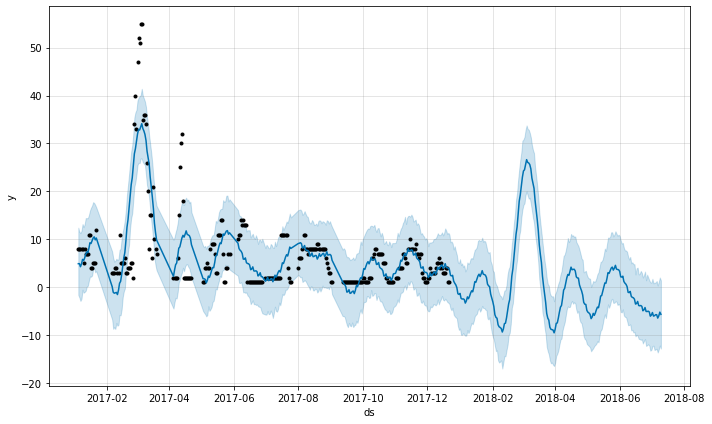

In [87]:
#4. Plot the created issues forecast by calling the Prophet.plot method and passing in your forecast dataframe
def predict_plot(file):
    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
    df = pd.read_csv(file)
    df_created = df['created_at'].value_counts().rename_axis('ds').reset_index(name='y')
    m.fit(df_created)
    future = m.make_future_dataframe(periods=200)
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    
predict_plot('issues.csv')


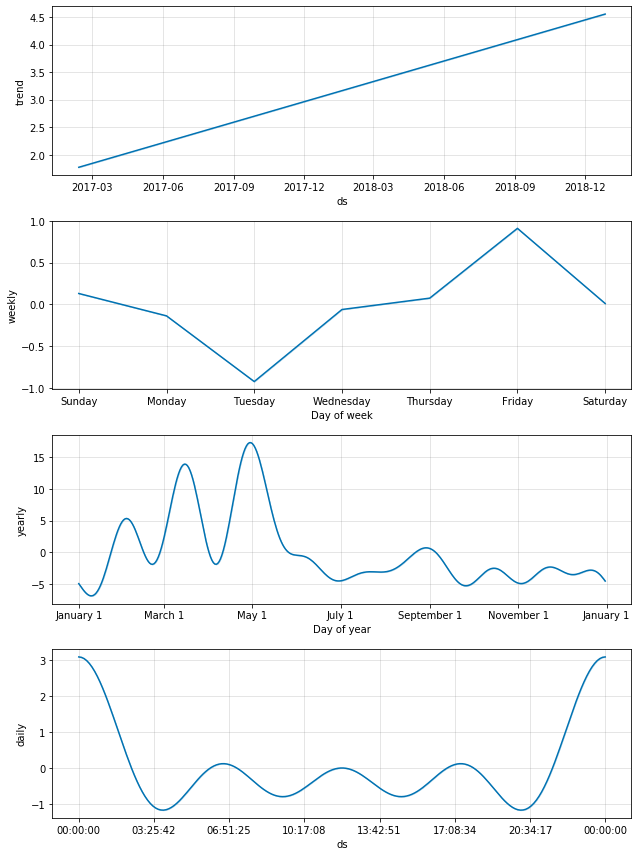

In [88]:
#5. Plot the closed issues forecast; use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

def predict_plot_closed(file):
    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
    df = pd.read_csv(file)
    df_closed = df['closed_at'].value_counts().rename_axis('ds').reset_index(name='y')
    m.fit(df_closed)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    fig1 = m.plot_components(forecast)
    
predict_plot_closed('issues.csv')

In [89]:
#statsmodel
issuesdf = pd.read_csv('issues.csv')
df = pd.read_csv('github_data.csv')
df

,ds,y
0,01-05-2017,8
1,01-06-2017,8
2,01-07-2017,8
3,01-08-2017,8
4,01-09-2017,8
...,...,...
283,9-26-2017,1
284,9-27-2017,1
285,9-28-2017,1
286,9-29-2017,1


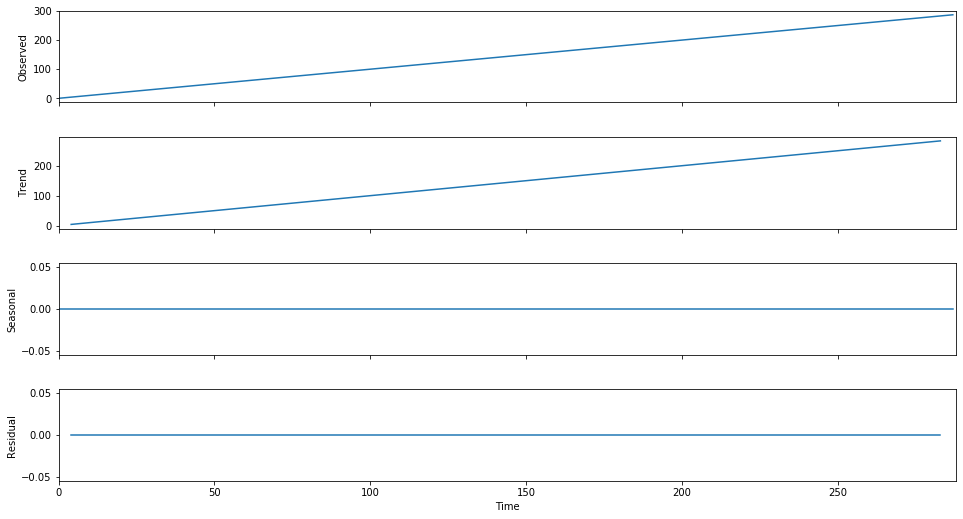

In [90]:
df.set_index('ds')
predict = sm.tsa.seasonal_decompose(df.index, freq=8)
figure = predict.plot()
figure.set_size_inches(15, 8)

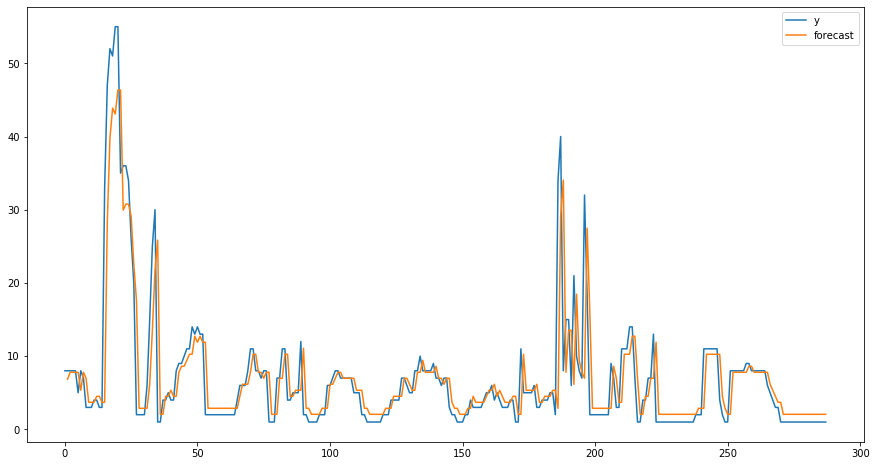

In [91]:
df2 = df
model = sm.tsa.ARIMA(df2['y'].iloc[1:], order = (1, 0, 0))
results = model.fit()
df2['forecast'] = results.fittedvalues
df2[['y', 'forecast']].plot(figsize=(15,8))



In [92]:
# 1. The day of the weeek maximum number of issues created : STATSMODEL

from datetime import date

def most_num_of_issues_created(dataframe):
    data = (dataframe.groupby(['created_at']).count().reset_index()).sort_values('issue_number', ascending=False).head(1).iloc[0]['created_at']
    return data

most_issues_created = most_num_of_issues_created(issuesdf) 

def convert(param):
    ans = datetime.date(pd.to_datetime(param)) 
    return ans.strftime("%A")

print("Day of week with max number of created_issues = ",most_issues_created, convert(most_issues_created)) 
      

Day of week with max number of created_issues =  03-06-2017 Monday


In [93]:
# 2. The day of the week maximum number of issues closed : STATSMODEL

def most_num_of_issues_closed(dataframe):
    data = (dataframe.groupby(['closed_at']).count().reset_index()).sort_values('issue_number', ascending=False).head(1).iloc[0]['closed_at']
    return data

max_issues_closed = most_num_of_issues_closed(issuesdf)

def convert(param):
    ans = datetime.date(pd.to_datetime(param)) 
    return ans.strftime("%A")
print("Day of week with max num of closed_issues",max_issues_closed, convert(max_issues_closed) )

Day of week with max num of closed_issues 03-10-2017 Friday


In [94]:
#3. the month of the year that has maximum number of issues closed : STATSMODEL
issuesdf['closed_month_year'] = pd.to_datetime(issuesdf['closed_at']).dt.to_period ('M')

max_issues_closed = issuesdf.groupby('closed_month_year').count()['issue_number'].idxmax(axis=0, skipna = True)

print("The month of the year that has maximum number of issues closed :", max_issues_closed.strftime('%B %F'))

The month of the year that has maximum number of issues closed : March 2017


['01-05-2017' '01-06-2017' '01-07-2017' '01-08-2017' '01-09-2017'
 '01-10-2017' '01-11-2017' '01-12-2017' '02-06-2017' '02-07-2017'
 '02-08-2017' '02-09-2017' '02-10-2017' '02-11-2017' '02-12-2017'
 '03-01-2017' '03-02-2017' '03-03-2017' '03-04-2017' '03-05-2017'
 '03-06-2017' '03-07-2017' '03-08-2017' '03-09-2017' '03-10-2017'
 '03-11-2017' '03-12-2017' '04-05-2017' '04-06-2017' '04-07-2017'
 '04-08-2017' '04-09-2017' '04-10-2017' '04-11-2017' '04-12-2017'
 '05-03-2017' '05-04-2017' '05-05-2017' '05-06-2017' '05-07-2017'
 '05-08-2017' '05-09-2017' '05-10-2017' '05-11-2017' '05-12-2017'
 '06-05-2017' '06-06-2017' '06-07-2017' '06-08-2017' '06-09-2017'
 '06-10-2017' '06-11-2017' '06-12-2017' '07-01-2017' '07-02-2017'
 '07-03-2017' '07-04-2017' '07-05-2017' '07-06-2017' '07-07-2017'
 '07-08-2017' '07-09-2017' '07-10-2017' '07-11-2017' '07-12-2017'
 '08-01-2017' '08-02-2017' '08-03-2017' '08-04-2017' '08-05-2017'
 '08-06-2017' '08-07-2017' '08-08-2017' '08-09-2017' '08-10-2017'
 '08-11-20

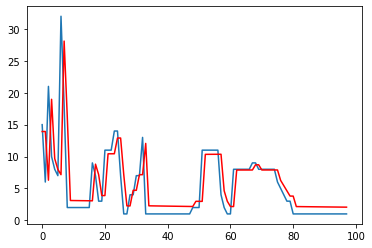

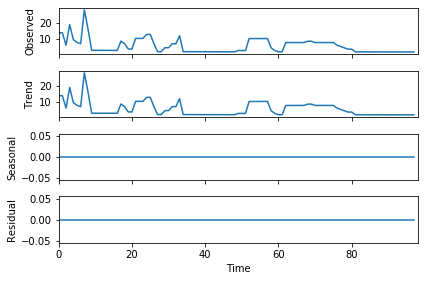

In [95]:
#4. Plot the created issues forecast: STATSMODEL

from pandas import read_csv
#Statsmodel ii.4 Plot the created issues import tensorflow as tf
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

def parse_date(x): 
    print(x)
    return datetime.strptime(x, '%m-%d-%Y')

def stat_fun_1(series):
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)] 
    history = [x for x in train] 
    predictions_data = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(1,0,0)) 
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0] 
        predictions_data.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions_data) 
    print('Test MSE: %.3f' % error)
    # plot
    plt.plot(test)
    plt.plot(predictions_data, color='red')
    plt.show()
    result = seasonal_decompose(list(predictions_data), model='additive', freq=1) 
    result.plot()
    plt.show()
    
def statsmodel_dataframe_created(temp_df):
    b = temp_df.groupby(['created_at'])['created_at'] 
    b1 = b.describe()
    temp = pd.DataFrame()
    temp = b1[['top', 'count']]
    temp.columns = ['ds', 'y']
    return temp

sm_df = pd.DataFrame(statsmodel_dataframe_created(issuesdf)) 
sm_df.to_csv('created_issues_stat.csv', sep = ',', encoding = 'utf-8', index = False) 

#Plotting 
series = read_csv('created_issues_stat.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parse_date)
stat_fun_1(series)

['02-12-2017' '03-03-2017' '03-04-2017' '03-07-2017' '03-08-2017'
 '03-09-2017' '03-10-2017' '03-11-2017' '03-12-2017' '04-02-2017'
 '04-03-2017' '04-05-2017' '04-06-2017' '04-09-2017' '04-10-2017'
 '04-12-2017' '06-03-2017' '06-05-2017' '06-06-2017' '06-08-2017'
 '06-09-2017' '06-11-2017' '06-12-2017' '07-02-2017' '07-03-2017'
 '07-05-2017' '07-06-2017' '07-07-2017' '07-08-2017' '07-09-2017'
 '07-10-2017' '07-12-2017' '08-01-2017' '08-02-2017' '08-03-2017'
 '08-04-2017' '08-05-2017' '08-07-2017' '08-08-2017' '08-09-2017'
 '08-10-2017' '08-11-2017' '09-01-2017' '09-02-2017' '09-03-2017'
 '09-04-2017' '09-05-2017' '09-06-2017' '09-07-2017' '09-08-2017'
 '09-09-2017' '09-10-2017' '09-11-2017' '09-12-2017' '10-01-2017'
 '10-02-2017' '10-03-2017' '10-05-2017' '10-06-2017' '10-07-2017'
 '10-08-2017' '10-10-2017' '10-13-2017' '10-14-2017' '10-15-2017'
 '10-18-2017' '10-19-2017' '10-20-2017' '10-21-2017' '10-22-2017'
 '10-23-2017' '10-24-2017' '10-25-2017' '10-26-2017' '10-27-2017'
 '10-28-20

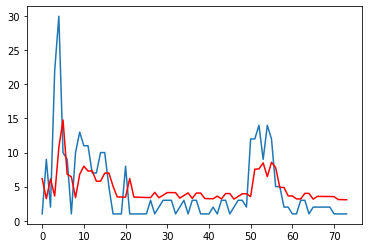

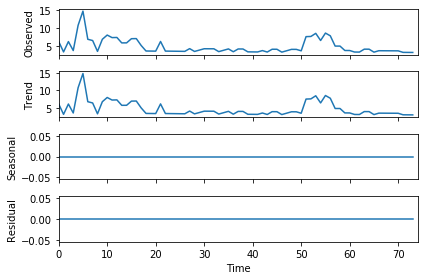

In [96]:
#5. Plot the closed issues forecast : STATSMODEL

def statsmodel_dataframe_closed(temp_df):
    b = temp_df.groupby(['closed_at'])['closed_at'] 
    b1 = b.describe()
    temp = pd.DataFrame()
    temp = b1[['top', 'count']]
    temp.columns = ['ds', 'y']
    return temp


sm_df = pd.DataFrame(statsmodel_dataframe_closed(issuesdf))
sm_df.to_csv('closed_issues_stat_closed.csv', sep = ',', encoding = 'utf-8', index = False)

#plotting 
series = read_csv('closed_issues_stat_closed.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parse_date)
stat_fun_1(series)

In [97]:
# Tensorflow
df = pd.read_csv('github_data.csv')
issuesdf = pd.read_csv('issues.csv')

In [98]:
df['ds'] = df['ds'].astype('datetime64[ns]')
array = df.to_numpy()
x = np.array([time.mktime(i[0].timetuple()) for i in array])
y = np.array([i[1] for i in array])


In [99]:
#get data for tensorflow
data = {
    tf.contrib.timeseries.TrainEvalFeatures.TIMES: x,
    tf.contrib.timeseries.TrainEvalFeatures.VALUES: y,
}
print (data)

reader = NumpyReader(data)

train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(reader, batch_size = 40, window_size = 40)
ar = tf.contrib.timeseries.ARRegressor(
        periodicities=200, input_window_size=30, output_window_size=10,
        num_features=1,
        loss=tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS)
ar.train(input_fn=train_input_fn, steps=6000)
#train_op = optimizer.minimize(loss, global_step = tf.train.get_global_step())

{'times': array([1.4835960e+09, 1.4836824e+09, 1.4837688e+09, 1.4838552e+09,
       1.4839416e+09, 1.4840280e+09, 1.4841144e+09, 1.4842008e+09,
       1.4863608e+09, 1.4864472e+09, 1.4865336e+09, 1.4866200e+09,
       1.4867064e+09, 1.4867928e+09, 1.4868792e+09, 1.4883480e+09,
       1.4884344e+09, 1.4885208e+09, 1.4886072e+09, 1.4886936e+09,
       1.4887800e+09, 1.4888664e+09, 1.4889528e+09, 1.4890392e+09,
       1.4891256e+09, 1.4892120e+09, 1.4892984e+09, 1.4913684e+09,
       1.4914548e+09, 1.4915412e+09, 1.4916276e+09, 1.4917140e+09,
       1.4918004e+09, 1.4918868e+09, 1.4919732e+09, 1.4937876e+09,
       1.4938740e+09, 1.4939604e+09, 1.4940468e+09, 1.4941332e+09,
       1.4942196e+09, 1.4943060e+09, 1.4943924e+09, 1.4944788e+09,
       1.4945652e+09, 1.4966388e+09, 1.4967252e+09, 1.4968116e+09,
       1.4968980e+09, 1.4969844e+09, 1.4970708e+09, 1.4971572e+09,
       1.4972436e+09, 1.4988852e+09, 1.4989716e+09, 1.4990580e+09,
       1.4991444e+09, 1.4992308e+09, 1.4993172e+09, 

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf01701e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf01701e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt.


INFO:tensorflow:loss = 1.1742582, step = 1


INFO:tensorflow:loss = 1.1742582, step = 1


INFO:tensorflow:global_step/sec: 191.953


INFO:tensorflow:global_step/sec: 191.953


INFO:tensorflow:loss = 0.8935287, step = 101 (0.522 sec)


INFO:tensorflow:loss = 0.8935287, step = 101 (0.522 sec)


INFO:tensorflow:global_step/sec: 145.149


INFO:tensorflow:global_step/sec: 145.149


INFO:tensorflow:loss = 0.82280767, step = 201 (0.689 sec)


INFO:tensorflow:loss = 0.82280767, step = 201 (0.689 sec)


INFO:tensorflow:global_step/sec: 145.243


INFO:tensorflow:global_step/sec: 145.243


INFO:tensorflow:loss = 0.8279248, step = 301 (0.688 sec)


INFO:tensorflow:loss = 0.8279248, step = 301 (0.688 sec)


INFO:tensorflow:global_step/sec: 146.282


INFO:tensorflow:global_step/sec: 146.282


INFO:tensorflow:loss = 0.7996957, step = 401 (0.683 sec)


INFO:tensorflow:loss = 0.7996957, step = 401 (0.683 sec)


INFO:tensorflow:global_step/sec: 145.868


INFO:tensorflow:global_step/sec: 145.868


INFO:tensorflow:loss = 0.84899914, step = 501 (0.686 sec)


INFO:tensorflow:loss = 0.84899914, step = 501 (0.686 sec)


INFO:tensorflow:global_step/sec: 144.169


INFO:tensorflow:global_step/sec: 144.169


INFO:tensorflow:loss = 0.7898318, step = 601 (0.694 sec)


INFO:tensorflow:loss = 0.7898318, step = 601 (0.694 sec)


INFO:tensorflow:global_step/sec: 144.492


INFO:tensorflow:global_step/sec: 144.492


INFO:tensorflow:loss = 0.785343, step = 701 (0.692 sec)


INFO:tensorflow:loss = 0.785343, step = 701 (0.692 sec)


INFO:tensorflow:global_step/sec: 146.99


INFO:tensorflow:global_step/sec: 146.99


INFO:tensorflow:loss = 0.82011956, step = 801 (0.680 sec)


INFO:tensorflow:loss = 0.82011956, step = 801 (0.680 sec)


INFO:tensorflow:global_step/sec: 144.934


INFO:tensorflow:global_step/sec: 144.934


INFO:tensorflow:loss = 0.8073518, step = 901 (0.690 sec)


INFO:tensorflow:loss = 0.8073518, step = 901 (0.690 sec)


INFO:tensorflow:global_step/sec: 143.217


INFO:tensorflow:global_step/sec: 143.217


INFO:tensorflow:loss = 0.82479894, step = 1001 (0.698 sec)


INFO:tensorflow:loss = 0.82479894, step = 1001 (0.698 sec)


INFO:tensorflow:global_step/sec: 143.992


INFO:tensorflow:global_step/sec: 143.992


INFO:tensorflow:loss = 0.8285986, step = 1101 (0.694 sec)


INFO:tensorflow:loss = 0.8285986, step = 1101 (0.694 sec)


INFO:tensorflow:global_step/sec: 146.182


INFO:tensorflow:global_step/sec: 146.182


INFO:tensorflow:loss = 0.81110096, step = 1201 (0.684 sec)


INFO:tensorflow:loss = 0.81110096, step = 1201 (0.684 sec)


INFO:tensorflow:global_step/sec: 143.823


INFO:tensorflow:global_step/sec: 143.823


INFO:tensorflow:loss = 0.70926404, step = 1301 (0.695 sec)


INFO:tensorflow:loss = 0.70926404, step = 1301 (0.695 sec)


INFO:tensorflow:global_step/sec: 148.103


INFO:tensorflow:global_step/sec: 148.103


INFO:tensorflow:loss = 0.73773336, step = 1401 (0.675 sec)


INFO:tensorflow:loss = 0.73773336, step = 1401 (0.675 sec)


INFO:tensorflow:global_step/sec: 136.631


INFO:tensorflow:global_step/sec: 136.631


INFO:tensorflow:loss = 0.7261714, step = 1501 (0.732 sec)


INFO:tensorflow:loss = 0.7261714, step = 1501 (0.732 sec)


INFO:tensorflow:global_step/sec: 145.135


INFO:tensorflow:global_step/sec: 145.135


INFO:tensorflow:loss = 0.74378425, step = 1601 (0.689 sec)


INFO:tensorflow:loss = 0.74378425, step = 1601 (0.689 sec)


INFO:tensorflow:global_step/sec: 145.46


INFO:tensorflow:global_step/sec: 145.46


INFO:tensorflow:loss = 0.733501, step = 1701 (0.687 sec)


INFO:tensorflow:loss = 0.733501, step = 1701 (0.687 sec)


INFO:tensorflow:global_step/sec: 143.063


INFO:tensorflow:global_step/sec: 143.063


INFO:tensorflow:loss = 0.71344876, step = 1801 (0.699 sec)


INFO:tensorflow:loss = 0.71344876, step = 1801 (0.699 sec)


INFO:tensorflow:global_step/sec: 144.91


INFO:tensorflow:global_step/sec: 144.91


INFO:tensorflow:loss = 0.70226383, step = 1901 (0.690 sec)


INFO:tensorflow:loss = 0.70226383, step = 1901 (0.690 sec)


INFO:tensorflow:global_step/sec: 146.765


INFO:tensorflow:global_step/sec: 146.765


INFO:tensorflow:loss = 0.771028, step = 2001 (0.681 sec)


INFO:tensorflow:loss = 0.771028, step = 2001 (0.681 sec)


INFO:tensorflow:global_step/sec: 146.201


INFO:tensorflow:global_step/sec: 146.201


INFO:tensorflow:loss = 0.7279149, step = 2101 (0.684 sec)


INFO:tensorflow:loss = 0.7279149, step = 2101 (0.684 sec)


INFO:tensorflow:global_step/sec: 145.12


INFO:tensorflow:global_step/sec: 145.12


INFO:tensorflow:loss = 0.7437529, step = 2201 (0.689 sec)


INFO:tensorflow:loss = 0.7437529, step = 2201 (0.689 sec)


INFO:tensorflow:global_step/sec: 144.663


INFO:tensorflow:global_step/sec: 144.663


INFO:tensorflow:loss = 0.73540145, step = 2301 (0.691 sec)


INFO:tensorflow:loss = 0.73540145, step = 2301 (0.691 sec)


INFO:tensorflow:global_step/sec: 142.353


INFO:tensorflow:global_step/sec: 142.353


INFO:tensorflow:loss = 0.7887724, step = 2401 (0.702 sec)


INFO:tensorflow:loss = 0.7887724, step = 2401 (0.702 sec)


INFO:tensorflow:global_step/sec: 144.88


INFO:tensorflow:global_step/sec: 144.88


INFO:tensorflow:loss = 0.80012554, step = 2501 (0.690 sec)


INFO:tensorflow:loss = 0.80012554, step = 2501 (0.690 sec)


INFO:tensorflow:global_step/sec: 145.696


INFO:tensorflow:global_step/sec: 145.696


INFO:tensorflow:loss = 0.67650855, step = 2601 (0.686 sec)


INFO:tensorflow:loss = 0.67650855, step = 2601 (0.686 sec)


INFO:tensorflow:global_step/sec: 144.841


INFO:tensorflow:global_step/sec: 144.841


INFO:tensorflow:loss = 0.7246661, step = 2701 (0.690 sec)


INFO:tensorflow:loss = 0.7246661, step = 2701 (0.690 sec)


INFO:tensorflow:global_step/sec: 145.002


INFO:tensorflow:global_step/sec: 145.002


INFO:tensorflow:loss = 0.78800786, step = 2801 (0.690 sec)


INFO:tensorflow:loss = 0.78800786, step = 2801 (0.690 sec)


INFO:tensorflow:global_step/sec: 145.397


INFO:tensorflow:global_step/sec: 145.397


INFO:tensorflow:loss = 0.7473666, step = 2901 (0.688 sec)


INFO:tensorflow:loss = 0.7473666, step = 2901 (0.688 sec)


INFO:tensorflow:global_step/sec: 143.394


INFO:tensorflow:global_step/sec: 143.394


INFO:tensorflow:loss = 0.6989927, step = 3001 (0.698 sec)


INFO:tensorflow:loss = 0.6989927, step = 3001 (0.698 sec)


INFO:tensorflow:global_step/sec: 145.246


INFO:tensorflow:global_step/sec: 145.246


INFO:tensorflow:loss = 0.6838574, step = 3101 (0.688 sec)


INFO:tensorflow:loss = 0.6838574, step = 3101 (0.688 sec)


INFO:tensorflow:global_step/sec: 145.325


INFO:tensorflow:global_step/sec: 145.325


INFO:tensorflow:loss = 0.6576452, step = 3201 (0.688 sec)


INFO:tensorflow:loss = 0.6576452, step = 3201 (0.688 sec)


INFO:tensorflow:global_step/sec: 146.007


INFO:tensorflow:global_step/sec: 146.007


INFO:tensorflow:loss = 0.6723913, step = 3301 (0.685 sec)


INFO:tensorflow:loss = 0.6723913, step = 3301 (0.685 sec)


INFO:tensorflow:global_step/sec: 145.738


INFO:tensorflow:global_step/sec: 145.738


INFO:tensorflow:loss = 0.7514761, step = 3401 (0.686 sec)


INFO:tensorflow:loss = 0.7514761, step = 3401 (0.686 sec)


INFO:tensorflow:global_step/sec: 146.643


INFO:tensorflow:global_step/sec: 146.643


INFO:tensorflow:loss = 0.6445804, step = 3501 (0.682 sec)


INFO:tensorflow:loss = 0.6445804, step = 3501 (0.682 sec)


INFO:tensorflow:global_step/sec: 144.232


INFO:tensorflow:global_step/sec: 144.232


INFO:tensorflow:loss = 0.7299632, step = 3601 (0.693 sec)


INFO:tensorflow:loss = 0.7299632, step = 3601 (0.693 sec)


INFO:tensorflow:global_step/sec: 147.304


INFO:tensorflow:global_step/sec: 147.304


INFO:tensorflow:loss = 0.74484783, step = 3701 (0.679 sec)


INFO:tensorflow:loss = 0.74484783, step = 3701 (0.679 sec)


INFO:tensorflow:global_step/sec: 146.697


INFO:tensorflow:global_step/sec: 146.697


INFO:tensorflow:loss = 0.6711323, step = 3801 (0.682 sec)


INFO:tensorflow:loss = 0.6711323, step = 3801 (0.682 sec)


INFO:tensorflow:global_step/sec: 144.101


INFO:tensorflow:global_step/sec: 144.101


INFO:tensorflow:loss = 0.74910206, step = 3901 (0.694 sec)


INFO:tensorflow:loss = 0.74910206, step = 3901 (0.694 sec)


INFO:tensorflow:global_step/sec: 145.606


INFO:tensorflow:global_step/sec: 145.606


INFO:tensorflow:loss = 0.65817887, step = 4001 (0.687 sec)


INFO:tensorflow:loss = 0.65817887, step = 4001 (0.687 sec)


INFO:tensorflow:global_step/sec: 145.37


INFO:tensorflow:global_step/sec: 145.37


INFO:tensorflow:loss = 0.72360075, step = 4101 (0.688 sec)


INFO:tensorflow:loss = 0.72360075, step = 4101 (0.688 sec)


INFO:tensorflow:global_step/sec: 145.387


INFO:tensorflow:global_step/sec: 145.387


INFO:tensorflow:loss = 0.7745108, step = 4201 (0.688 sec)


INFO:tensorflow:loss = 0.7745108, step = 4201 (0.688 sec)


INFO:tensorflow:global_step/sec: 145.796


INFO:tensorflow:global_step/sec: 145.796


INFO:tensorflow:loss = 0.7876081, step = 4301 (0.686 sec)


INFO:tensorflow:loss = 0.7876081, step = 4301 (0.686 sec)


INFO:tensorflow:global_step/sec: 136.191


INFO:tensorflow:global_step/sec: 136.191


INFO:tensorflow:loss = 0.7237567, step = 4401 (0.735 sec)


INFO:tensorflow:loss = 0.7237567, step = 4401 (0.735 sec)


INFO:tensorflow:global_step/sec: 129.657


INFO:tensorflow:global_step/sec: 129.657


INFO:tensorflow:loss = 0.70355237, step = 4501 (0.771 sec)


INFO:tensorflow:loss = 0.70355237, step = 4501 (0.771 sec)


INFO:tensorflow:global_step/sec: 138.309


INFO:tensorflow:global_step/sec: 138.309


INFO:tensorflow:loss = 0.7436478, step = 4601 (0.723 sec)


INFO:tensorflow:loss = 0.7436478, step = 4601 (0.723 sec)


INFO:tensorflow:global_step/sec: 137.243


INFO:tensorflow:global_step/sec: 137.243


INFO:tensorflow:loss = 0.7039898, step = 4701 (0.728 sec)


INFO:tensorflow:loss = 0.7039898, step = 4701 (0.728 sec)


INFO:tensorflow:global_step/sec: 144.234


INFO:tensorflow:global_step/sec: 144.234


INFO:tensorflow:loss = 0.8143608, step = 4801 (0.693 sec)


INFO:tensorflow:loss = 0.8143608, step = 4801 (0.693 sec)


INFO:tensorflow:global_step/sec: 146.477


INFO:tensorflow:global_step/sec: 146.477


INFO:tensorflow:loss = 0.7548163, step = 4901 (0.683 sec)


INFO:tensorflow:loss = 0.7548163, step = 4901 (0.683 sec)


INFO:tensorflow:global_step/sec: 146.465


INFO:tensorflow:global_step/sec: 146.465


INFO:tensorflow:loss = 0.7269412, step = 5001 (0.683 sec)


INFO:tensorflow:loss = 0.7269412, step = 5001 (0.683 sec)


INFO:tensorflow:global_step/sec: 139.662


INFO:tensorflow:global_step/sec: 139.662


INFO:tensorflow:loss = 0.6949016, step = 5101 (0.716 sec)


INFO:tensorflow:loss = 0.6949016, step = 5101 (0.716 sec)


INFO:tensorflow:global_step/sec: 138.997


INFO:tensorflow:global_step/sec: 138.997


INFO:tensorflow:loss = 0.6816639, step = 5201 (0.720 sec)


INFO:tensorflow:loss = 0.6816639, step = 5201 (0.720 sec)


INFO:tensorflow:global_step/sec: 127.36


INFO:tensorflow:global_step/sec: 127.36


INFO:tensorflow:loss = 0.71083957, step = 5301 (0.785 sec)


INFO:tensorflow:loss = 0.71083957, step = 5301 (0.785 sec)


INFO:tensorflow:global_step/sec: 136.297


INFO:tensorflow:global_step/sec: 136.297


INFO:tensorflow:loss = 0.70206356, step = 5401 (0.734 sec)


INFO:tensorflow:loss = 0.70206356, step = 5401 (0.734 sec)


INFO:tensorflow:global_step/sec: 138.731


INFO:tensorflow:global_step/sec: 138.731


INFO:tensorflow:loss = 0.74185395, step = 5501 (0.721 sec)


INFO:tensorflow:loss = 0.74185395, step = 5501 (0.721 sec)


INFO:tensorflow:global_step/sec: 144.572


INFO:tensorflow:global_step/sec: 144.572


INFO:tensorflow:loss = 0.695399, step = 5601 (0.692 sec)


INFO:tensorflow:loss = 0.695399, step = 5601 (0.692 sec)


INFO:tensorflow:global_step/sec: 140.951


INFO:tensorflow:global_step/sec: 140.951


INFO:tensorflow:loss = 0.6712694, step = 5701 (0.709 sec)


INFO:tensorflow:loss = 0.6712694, step = 5701 (0.709 sec)


INFO:tensorflow:global_step/sec: 140.544


INFO:tensorflow:global_step/sec: 140.544


INFO:tensorflow:loss = 0.8122556, step = 5801 (0.711 sec)


INFO:tensorflow:loss = 0.8122556, step = 5801 (0.711 sec)


INFO:tensorflow:global_step/sec: 141.835


INFO:tensorflow:global_step/sec: 141.835


INFO:tensorflow:loss = 0.6804515, step = 5901 (0.705 sec)


INFO:tensorflow:loss = 0.6804515, step = 5901 (0.705 sec)


INFO:tensorflow:Saving checkpoints for 6000 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt.


INFO:tensorflow:Loss for final step: 0.68594474.


INFO:tensorflow:Loss for final step: 0.68594474.


In [100]:
#evaluation

evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
evaluation = ar.evaluate(input_fn=evaluation_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-12-01T22:08:02Z


INFO:tensorflow:Starting evaluation at 2020-12-01T22:08:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt-6000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [100/1000]


INFO:tensorflow:Evaluation [100/1000]


INFO:tensorflow:Evaluation [200/1000]


INFO:tensorflow:Evaluation [200/1000]


INFO:tensorflow:Evaluation [300/1000]


INFO:tensorflow:Evaluation [300/1000]


INFO:tensorflow:Evaluation [400/1000]


INFO:tensorflow:Evaluation [400/1000]


INFO:tensorflow:Evaluation [500/1000]


INFO:tensorflow:Evaluation [500/1000]


INFO:tensorflow:Evaluation [600/1000]


INFO:tensorflow:Evaluation [600/1000]


INFO:tensorflow:Evaluation [700/1000]


INFO:tensorflow:Evaluation [700/1000]


INFO:tensorflow:Evaluation [800/1000]


INFO:tensorflow:Evaluation [800/1000]


INFO:tensorflow:Evaluation [900/1000]


INFO:tensorflow:Evaluation [900/1000]


INFO:tensorflow:Evaluation [1000/1000]


INFO:tensorflow:Evaluation [1000/1000]


INFO:tensorflow:Finished evaluation at 2020-12-01-22:08:06


INFO:tensorflow:Finished evaluation at 2020-12-01-22:08:06


INFO:tensorflow:Saving dict for global step 6000: average_loss = 1.6794804, covariance = [[[2.03796554e+00]
  [2.40742898e+00]
  [5.75269818e-01]
  [1.55298877e+00]
  [2.79150367e+00]
  [6.71850860e-01]
  [4.56455278e+00]
  [1.51915073e+00]
  [3.90309811e-01]
  [2.56905764e-01]
  [9.14510059e+00]
  [2.79724503e+01]
  [2.30527782e+01]
  [1.18646979e+00]
  [7.54935026e-01]
  [8.00817490e-01]
  [8.47767234e-01]
  [1.63070595e+00]
  [5.16378701e-01]
  [2.71619707e-01]
  [6.44626915e-01]
  [3.46324730e+00]
  [6.85278320e+01]
  [3.10721893e+01]
  [2.37721615e+01]
  [1.43572741e+01]
  [2.20001183e+01]
  [9.66532040e+00]
  [2.12271900e+01]
  [4.84945583e+00]
  [1.67086351e+00]
  [3.14499283e+00]
  [3.84255886e+00]
  [1.13961306e+01]
  [1.22727280e+01]
  [1.81096191e+01]
  [2.08881874e+01]
  [2.60300159e+01]
  [1.61351128e+01]
  [1.56450214e+01]
  [8.82918262e+00]
  [3.77232094e+01]
  [2.44595222e+01]
  [5.21056709e+01]
  [2.99469070e+01]
  [2.63249283e+01]
  [1.45082264e+01]
  [1.43712358e+01]

INFO:tensorflow:Saving dict for global step 6000: average_loss = 1.6794804, covariance = [[[2.03796554e+00]
  [2.40742898e+00]
  [5.75269818e-01]
  [1.55298877e+00]
  [2.79150367e+00]
  [6.71850860e-01]
  [4.56455278e+00]
  [1.51915073e+00]
  [3.90309811e-01]
  [2.56905764e-01]
  [9.14510059e+00]
  [2.79724503e+01]
  [2.30527782e+01]
  [1.18646979e+00]
  [7.54935026e-01]
  [8.00817490e-01]
  [8.47767234e-01]
  [1.63070595e+00]
  [5.16378701e-01]
  [2.71619707e-01]
  [6.44626915e-01]
  [3.46324730e+00]
  [6.85278320e+01]
  [3.10721893e+01]
  [2.37721615e+01]
  [1.43572741e+01]
  [2.20001183e+01]
  [9.66532040e+00]
  [2.12271900e+01]
  [4.84945583e+00]
  [1.67086351e+00]
  [3.14499283e+00]
  [3.84255886e+00]
  [1.13961306e+01]
  [1.22727280e+01]
  [1.81096191e+01]
  [2.08881874e+01]
  [2.60300159e+01]
  [1.61351128e+01]
  [1.56450214e+01]
  [8.82918262e+00]
  [3.77232094e+01]
  [2.44595222e+01]
  [5.21056709e+01]
  [2.99469070e+01]
  [2.63249283e+01]
  [1.45082264e+01]
  [1.43712358e+01]

INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt-6000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt-6000


In [101]:
#prediction
(predictions,) = tuple(ar.predict(
        input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
            evaluation, steps=365)))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt-6000


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpugbt6rlz/model.ckpt-6000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


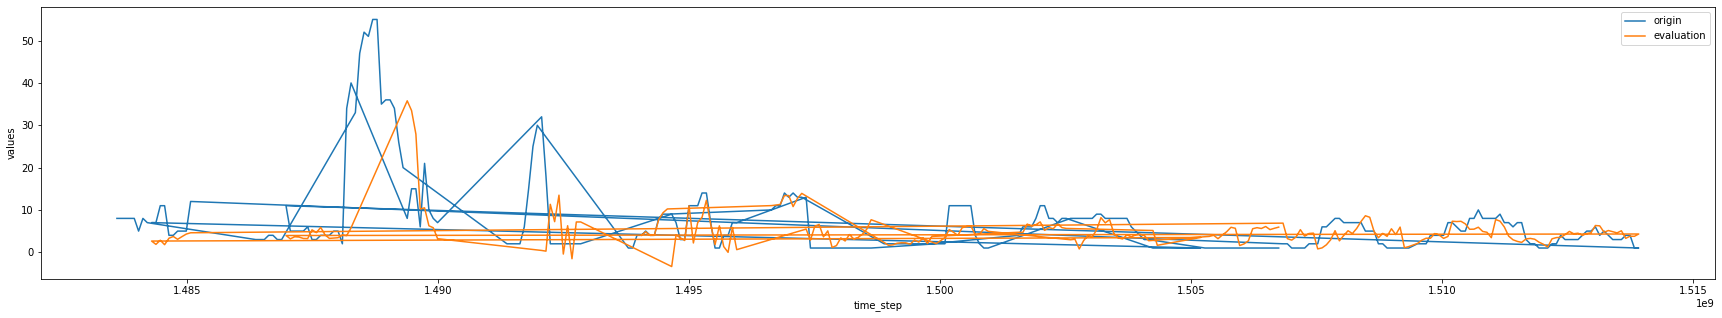

In [102]:
#plot origin and evaluation 
plt.figure(figsize=(30, 5))
plt.plot(data['times'].reshape(-1), data['values'].reshape(-1), label='origin')
plt.plot(evaluation['times'].reshape(-1), evaluation['mean'].reshape(-1), label='evaluation')
plt.xlabel('time_step')
plt.ylabel('values')
plt.legend()
plt.show()

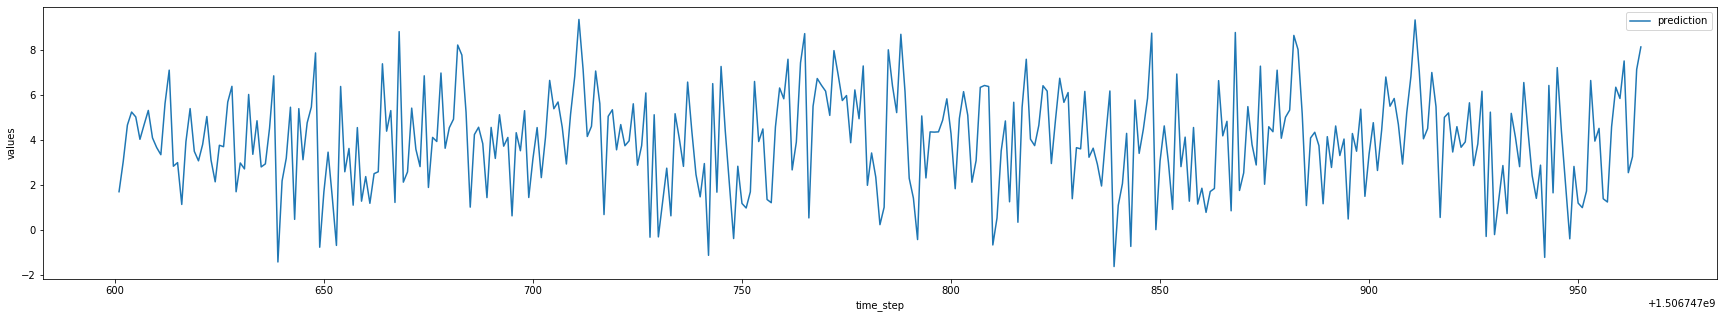

In [103]:
#plot prediction
plt.figure(figsize=(30, 5))
plt.plot(predictions['times'].reshape(-1), predictions['mean'].reshape(-1), label='prediction')
plt.xlabel('time_step')
plt.ylabel('values')
plt.legend()
plt.show()

In [104]:
# 1. The day of the weeek maximum number of issues created : TFTS
from datetime import date
#import calender
def most_num_of_issues_created(dataframe):
    data = (dataframe.groupby(['created_at']).count().reset_index()).sort_values('issue_number', ascending=False).head(1).iloc[0]['created_at']
    return data

max_number_issues_created = most_num_of_issues_created(issuesdf)

def convert(param):
    ans = datetime.date(pd.to_datetime(param))
    return ans.strftime("%A")

print("Day of week with max num of created_issues = ", max_number_issues_created, convert(max_number_issues_created))

Day of week with max num of created_issues =  03-06-2017 Monday


In [105]:
# 2. The day of the week maximum number of issues closed : TFTS

from datetime import date
#import calender
def most_num_of_issues_closed(dataframe):
    data = (dataframe.groupby(['closed_at']).count().reset_index()).sort_values('issue_number', ascending=False).head(1).iloc[0]['closed_at']
    return data

max_issues_closed = most_num_of_issues_closed(issuesdf)

def convert(param):
    ans = datetime.date(pd.to_datetime(param))
    return ans.strftime("%A")

print("Day of week with max num of closed_issues = ",max_issues_closed,convert(max_issues_closed))

Day of week with max num of closed_issues =  03-10-2017 Friday


In [106]:
#3. the month of the year that has maximum number of issues closed : TFTS

# Adding new column closed_month_year to new dataframes
issuesdf['closed_month_year'] = pd.to_datetime(issuesdf['closed_at']).dt.to_period('M')

max_no_issues_closed = issuesdf.groupby('closed_month_year').count()['issue_number'].idxmax(axis=0, skipna = True)

print("The month of the year that has maximum number of issues closed :",max_no_issues_closed.strftime('%B %F'))

The month of the year that has maximum number of issues closed : March 2017


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf1989bf90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf1989bf90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt.


INFO:tensorflow:loss = 1.5443797, step = 1


INFO:tensorflow:loss = 1.5443797, step = 1


INFO:tensorflow:global_step/sec: 635.724


INFO:tensorflow:global_step/sec: 635.724


INFO:tensorflow:loss = 1.0433427, step = 101 (0.159 sec)


INFO:tensorflow:loss = 1.0433427, step = 101 (0.159 sec)


INFO:tensorflow:global_step/sec: 1243.67


INFO:tensorflow:global_step/sec: 1243.67


INFO:tensorflow:loss = 0.88014513, step = 201 (0.081 sec)


INFO:tensorflow:loss = 0.88014513, step = 201 (0.081 sec)


INFO:tensorflow:global_step/sec: 1250.92


INFO:tensorflow:global_step/sec: 1250.92


INFO:tensorflow:loss = 0.9834051, step = 301 (0.079 sec)


INFO:tensorflow:loss = 0.9834051, step = 301 (0.079 sec)


INFO:tensorflow:global_step/sec: 1614.42


INFO:tensorflow:global_step/sec: 1614.42


INFO:tensorflow:loss = 0.95913965, step = 401 (0.062 sec)


INFO:tensorflow:loss = 0.95913965, step = 401 (0.062 sec)


INFO:tensorflow:global_step/sec: 1426.58


INFO:tensorflow:global_step/sec: 1426.58


INFO:tensorflow:loss = 1.7004888, step = 501 (0.071 sec)


INFO:tensorflow:loss = 1.7004888, step = 501 (0.071 sec)


INFO:tensorflow:Saving checkpoints for 600 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt.


INFO:tensorflow:Loss for final step: 0.8988972.


INFO:tensorflow:Loss for final step: 0.8988972.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-12-01T22:08:10Z


INFO:tensorflow:Starting evaluation at 2020-12-01T22:08:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt-600


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt-600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Finished evaluation at 2020-12-01-22:08:10


INFO:tensorflow:Finished evaluation at 2020-12-01-22:08:10


INFO:tensorflow:Saving dict for global step 600: average_loss = 1.0688831, covariance = [[[  42.888985]
  [  83.02664 ]
  [  42.888985]
  [  83.02664 ]
  [  35.509346]
  [  68.56391 ]
  [  40.27276 ]
  [  77.89511 ]
  [  29.517265]
  [  63.874847]
  [  31.434782]
  [  68.08276 ]
  [  29.867281]
  [  63.153893]
  [ 195.03244 ]
  [ 433.06073 ]
  [1083.23    ]
  [ 883.23706 ]
  [1371.5198  ]
  [1022.0685  ]
  [ 408.313   ]
  [ 272.6559  ]
  [ 347.58072 ]
  [ 360.56866 ]
  [ 180.9143  ]
  [ 194.88329 ]
  [  33.866817]
  [  49.41017 ]
  [  27.391903]
  [  60.611126]
  [  35.23381 ]
  [  78.23148 ]
  [ 135.78969 ]
  [ 226.84698 ]
  [  35.779625]
  [  41.38198 ]
  [  30.702328]
  [  69.646095]
  [  33.873837]
  [  71.74881 ]
  [  31.807535]
  [  67.31431 ]
  [  45.675163]
  [  88.49623 ]
  [  49.21914 ]
  [  93.261475]
  [  53.667027]
  [  97.17399 ]
  [  63.05724 ]
  [ 106.702675]
  [  63.05724 ]
  [ 106.702675]
  [  31.184402]
  [  53.49643 ]
  [  27.391903]
  [  60.611126]
  [  27.391903]


INFO:tensorflow:Saving dict for global step 600: average_loss = 1.0688831, covariance = [[[  42.888985]
  [  83.02664 ]
  [  42.888985]
  [  83.02664 ]
  [  35.509346]
  [  68.56391 ]
  [  40.27276 ]
  [  77.89511 ]
  [  29.517265]
  [  63.874847]
  [  31.434782]
  [  68.08276 ]
  [  29.867281]
  [  63.153893]
  [ 195.03244 ]
  [ 433.06073 ]
  [1083.23    ]
  [ 883.23706 ]
  [1371.5198  ]
  [1022.0685  ]
  [ 408.313   ]
  [ 272.6559  ]
  [ 347.58072 ]
  [ 360.56866 ]
  [ 180.9143  ]
  [ 194.88329 ]
  [  33.866817]
  [  49.41017 ]
  [  27.391903]
  [  60.611126]
  [  35.23381 ]
  [  78.23148 ]
  [ 135.78969 ]
  [ 226.84698 ]
  [  35.779625]
  [  41.38198 ]
  [  30.702328]
  [  69.646095]
  [  33.873837]
  [  71.74881 ]
  [  31.807535]
  [  67.31431 ]
  [  45.675163]
  [  88.49623 ]
  [  49.21914 ]
  [  93.261475]
  [  53.667027]
  [  97.17399 ]
  [  63.05724 ]
  [ 106.702675]
  [  63.05724 ]
  [ 106.702675]
  [  31.184402]
  [  53.49643 ]
  [  27.391903]
  [  60.611126]
  [  27.391903]


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt-600


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt-600


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt-600


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpy0_y9lhi/model.ckpt-600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


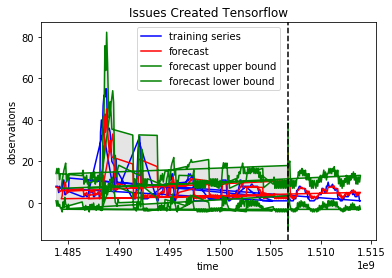

In [107]:
#4. Plot the created issues forecast: TFTS

import tensorflow as tf
import importlib
import dateparser
import time

def date_conversion(date_str):
    a = dateparser.parse(date_str)
    t1 = a.timetuple()
    return int(time.mktime(t1))

def ar_train_and_predict(csv_file_name):
    ar = tf.contrib.timeseries.ARRegressor(
        periodicities=200, input_window_size=2, output_window_size=2,
        num_features=1,
    # Use the (default) normal likelihood loss to adaptively fit the
    # variance. SQUARED_LOSS overestimates variance when there are trends in
    # the series.
        loss=tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS)
    return train_and_predict(ar, csv_file_name, training_steps=600)

def train_and_predict(estimator, csv_file_name, training_steps):
    data = pd.read_csv(csv_file_name, header=0)
    data['timestamp'] = data['timestamp'].apply(lambda x: date_conversion(x))
    reader = tf.contrib.timeseries.NumpyReader(data={tf.contrib.timeseries.TrainEvalFeatures.TIMES: data['timestamp'].values, tf.contrib.timeseries.TrainEvalFeatures.VALUES : data['values'].values})
    #reader = tf.contrib.timeseries.CSVReader(csv_file_name)
    # Set up windowing and batching for training
    train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(reader, batch_size=16, window_size=4)
    # Fit model parameters to data
    estimator.train(input_fn=train_input_fn, steps=training_steps)
    # Evaluate on the full dataset sequentially, collecting in-sample predictions
    # for a qualitative evaluation. Note that this loads the whole dataset into
    # memory. For quantitative evaluation, use RandomWindowChunker.
    evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)
    # Predict starting after the evaluation
    (predictions,) = tuple(estimator.predict(input_fn=tf.contrib.timeseries.predict_continuation_input_fn(evaluation, steps=1000)))
    times = evaluation["times"][0]
    observed = evaluation["observed"][0, :, 0]
    mean = np.squeeze(np.concatenate([evaluation["mean"][0], predictions["mean"]], axis=0))
    variance = np.squeeze(np.concatenate([evaluation["covariance"][0], predictions["covariance"]], axis=0))
    all_times = np.concatenate([times, predictions["times"]], axis=0)
    upper_limit = mean + np.sqrt(variance)
    lower_limit = mean - np.sqrt(variance)
    return times, observed, all_times, mean, upper_limit, lower_limit

def make_plot(name, training_times, observed, all_times, mean,upper_limit, lower_limit):
    plt.figure()
    plt.plot(training_times, observed, "b", label="training series")
    plt.plot(all_times, mean, "r", label="forecast")
    plt.plot(all_times, upper_limit, "g", label="forecast upper bound")
    plt.plot(all_times, lower_limit, "g", label="forecast lower bound")
    plt.fill_between(all_times, lower_limit, upper_limit, color="grey",alpha="0.2")
    plt.axvline(training_times[-1], color="k", linestyle="--")
    plt.xlabel("time")
    plt.ylabel("observations")
    plt.legend(loc=0)
    plt.title(name)
    

def tensorflow_dataframe(temp_df):
    b = temp_df.groupby(['created_at'])['created_at']
    b1 = b.describe()
    temp = pd.DataFrame()
    temp = b1[['top', 'count']]
    temp.columns = ['timestamp', 'values']
    columns = [x for x in temp.columns]
    datatowrite = temp[columns]
    return datatowrite

tensorflow_dataframe(issuesdf).to_csv('tensorflow_issues_create.csv', sep=',', encoding='utf-8',index=False)
make_plot("Issues Created Tensorflow", *ar_train_and_predict("tensorflow_issues_create.csv"))
plt.show()

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf1a3954d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf1a3954d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt.


INFO:tensorflow:loss = 1.8196876, step = 1


INFO:tensorflow:loss = 1.8196876, step = 1


INFO:tensorflow:global_step/sec: 589.151


INFO:tensorflow:global_step/sec: 589.151


INFO:tensorflow:loss = 1.7542549, step = 101 (0.171 sec)


INFO:tensorflow:loss = 1.7542549, step = 101 (0.171 sec)


INFO:tensorflow:global_step/sec: 1275.67


INFO:tensorflow:global_step/sec: 1275.67


INFO:tensorflow:loss = 1.1477034, step = 201 (0.078 sec)


INFO:tensorflow:loss = 1.1477034, step = 201 (0.078 sec)


INFO:tensorflow:global_step/sec: 1240.18


INFO:tensorflow:global_step/sec: 1240.18


INFO:tensorflow:loss = 0.9699066, step = 301 (0.081 sec)


INFO:tensorflow:loss = 0.9699066, step = 301 (0.081 sec)


INFO:tensorflow:global_step/sec: 1633.32


INFO:tensorflow:global_step/sec: 1633.32


INFO:tensorflow:loss = 2.093548, step = 401 (0.061 sec)


INFO:tensorflow:loss = 2.093548, step = 401 (0.061 sec)


INFO:tensorflow:global_step/sec: 1666.97


INFO:tensorflow:global_step/sec: 1666.97


INFO:tensorflow:loss = 1.2313025, step = 501 (0.060 sec)


INFO:tensorflow:loss = 1.2313025, step = 501 (0.060 sec)


INFO:tensorflow:Saving checkpoints for 600 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt.


INFO:tensorflow:Loss for final step: 0.89184976.


INFO:tensorflow:Loss for final step: 0.89184976.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-12-01T22:08:14Z


INFO:tensorflow:Starting evaluation at 2020-12-01T22:08:14Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt-600


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt-600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Finished evaluation at 2020-12-01-22:08:14


INFO:tensorflow:Finished evaluation at 2020-12-01-22:08:14


INFO:tensorflow:Saving dict for global step 600: average_loss = 1.0983461, covariance = [[[  93.92948 ]
  [1300.487   ]
  [  49.779022]
  [  72.566414]
  [ 382.24332 ]
  [  79.32507 ]
  [  57.019554]
  [  39.433468]
  [  42.636513]
  [  15.623931]
  [  35.514183]
  [  13.645474]
  [  42.636513]
  [  15.623931]
  [  55.85953 ]
  [  59.482327]
  [  47.181858]
  [  25.793745]
  [  39.041477]
  [  16.871897]
  [  47.181858]
  [  25.793745]
  [  35.514183]
  [  13.645474]
  [  36.733833]
  [  16.127363]
  [  36.733833]
  [  16.127363]
  [  35.514183]
  [  13.645474]
  [  37.995373]
  [  19.060663]
  [  51.187214]
  [  17.889244]
  [  46.528328]
  [  51.95009 ]
  [  44.983475]
  [  43.955334]
  [  58.97776 ]
  [  46.605766]
  [  42.636513]
  [  15.623931]
  [  51.86799 ]
  [  31.892582]
  [  40.382263]
  [  19.94062 ]
  [  52.21176 ]
  [  42.583225]
  [  48.80221 ]
  [  30.485205]
  [  42.9191  ]
  [  20.861195]
  [  36.733833]
  [  16.127363]
  [  36.733833]
  [  16.127363]
  [  37.745205]


INFO:tensorflow:Saving dict for global step 600: average_loss = 1.0983461, covariance = [[[  93.92948 ]
  [1300.487   ]
  [  49.779022]
  [  72.566414]
  [ 382.24332 ]
  [  79.32507 ]
  [  57.019554]
  [  39.433468]
  [  42.636513]
  [  15.623931]
  [  35.514183]
  [  13.645474]
  [  42.636513]
  [  15.623931]
  [  55.85953 ]
  [  59.482327]
  [  47.181858]
  [  25.793745]
  [  39.041477]
  [  16.871897]
  [  47.181858]
  [  25.793745]
  [  35.514183]
  [  13.645474]
  [  36.733833]
  [  16.127363]
  [  36.733833]
  [  16.127363]
  [  35.514183]
  [  13.645474]
  [  37.995373]
  [  19.060663]
  [  51.187214]
  [  17.889244]
  [  46.528328]
  [  51.95009 ]
  [  44.983475]
  [  43.955334]
  [  58.97776 ]
  [  46.605766]
  [  42.636513]
  [  15.623931]
  [  51.86799 ]
  [  31.892582]
  [  40.382263]
  [  19.94062 ]
  [  52.21176 ]
  [  42.583225]
  [  48.80221 ]
  [  30.485205]
  [  42.9191  ]
  [  20.861195]
  [  36.733833]
  [  16.127363]
  [  36.733833]
  [  16.127363]
  [  37.745205]


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt-600


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt-600


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt-600


INFO:tensorflow:Restoring parameters from /var/folders/xv/jcbrjhzs2cn3wh633pqxf63m0000gn/T/tmpi3d1htr4/model.ckpt-600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


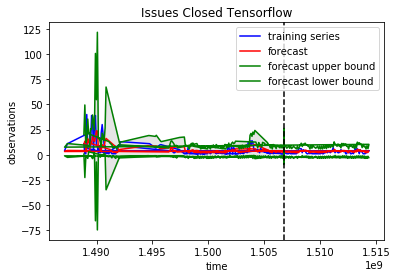

In [108]:
#5. Plot the closed issues forecast : TFTS
def tensorflow_dataframe_closed(temp_df):
    b = temp_df.groupby(['closed_at'])['closed_at']
    b1 = b.describe()
    temp = pd.DataFrame()
    temp = b1[['top', 'count']]
    temp.columns = ['timestamp', 'values']
    columns = [x for x in temp.columns]
    datatowrite = temp[columns]
    return datatowrite

tensorflow_dataframe_closed(issuesdf).to_csv('tensorflow_issues_closed.csv', sep=',', encoding='utf-8',index=False)
make_plot("Issues Closed Tensorflow", *ar_train_and_predict("tensorflow_issues_closed.csv"))
plt.show()
